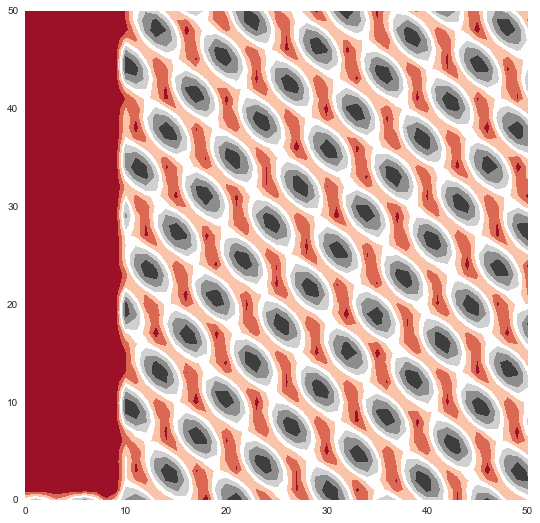

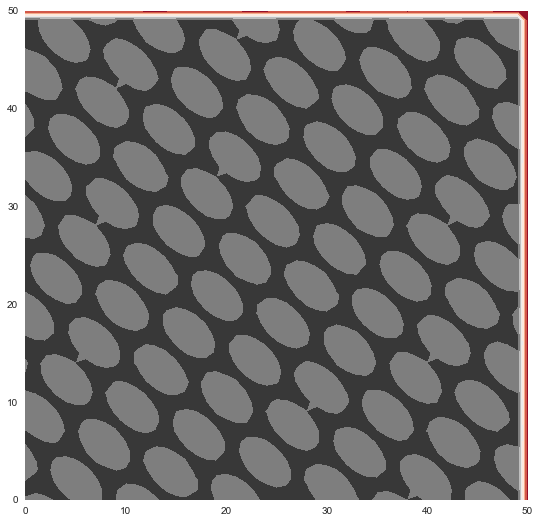

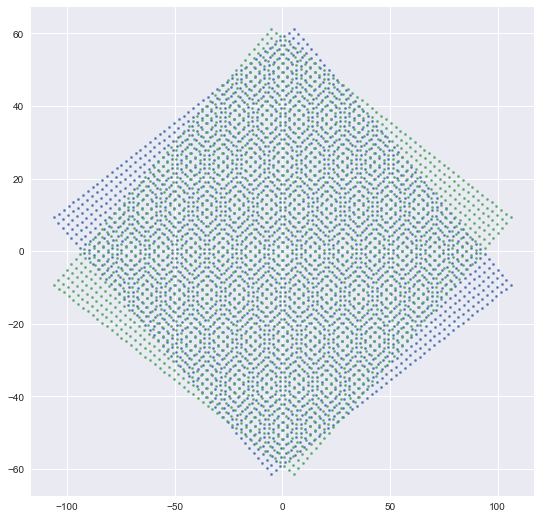

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

a = 2.46 # angstrom
angle = 10.0
theta  = angle*np.pi/180 # degree to rad
lat_vec1 = a*np.array([0.5*np.sqrt(3),0.5])
lat_vec2 = a*np.array([0.5*np.sqrt(3),-0.5])
N = 50

def Rotation(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

lat_vec_bottom1 = np.matmul(Rotation(-0.5*theta), lat_vec1)
lat_vec_bottom2 = np.matmul(Rotation(-0.5*theta), lat_vec2)
lat_vec_top1 = np.matmul(Rotation(0.5*theta), lat_vec1)
lat_vec_top2 = np.matmul(Rotation(0.5*theta), lat_vec2)

d0 = 3.35 # angstrom
a0 = 1.42 # angstrom

tau = a0*np.array([-1,0]) # shift from A to B
tau_bottom = np.matmul(Rotation(-0.5*theta), tau)
tau_top = np.matmul(Rotation(0.5*theta), tau)

def DistBottomTop(bottom_atom, sublattice_bottom, top_atom, sublattice_top):

    # bottom_atom and top_atom are indices [i,j] and [n,k] of lattice elements
    # sublattice =0 stands for A, =1 stands for B
    # returns distance between given atoms
    
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2+sublattice_bottom*tau_bottom
    vec_top_atom = top_atom[0]*lat_vec_top1+top_atom[1]*lat_vec_top2+sublattice_top*tau_top
    return np.sqrt(np.linalg.norm(vec_bottom_atom-vec_top_atom)**2+d0**2)
    
#print(DistBottomTop([0,0],1,[0,0],1))

def ExtractFirsts(lst):
    return [item[0] for item in lst]

def ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top):
    
    # finds [n,k] of atom from top layer within given sublattice_top
    # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
    # returns distance to closest atom and vector in plane which connects bottom atom to top atom
    
    dists = []
    window = int(1.1*theta*N) # a window which helps to shorten the area of searching for closest atom
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2+sublattice_bottom*tau_bottom
    for n in range(bottom_atom[0]-window, bottom_atom[0]+window):
        for k in range(bottom_atom[1]-window, bottom_atom[1]+window):
            dists.append([DistBottomTop(bottom_atom, sublattice_bottom,[n,k],sublattice_top),[n,k]])
    distances = ExtractFirsts(dists)
    index = np.argmin(np.array(distances))
    vec_top_atom = dists[index][1][0]*lat_vec_top1+dists[index][1][1]*lat_vec_top2 + sublattice_top*tau
    delta = vec_top_atom-vec_bottom_atom
    return [dists[index],delta]

def ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):
    
    # finds [n,k] of atom from top layer within given sublattice_top
    # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
    # returns distance to closest atom, its coordinates and vector in plane which connects bottom atom to top atom
    
    dists = []
    window = 4
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2+sublattice_bottom*tau_bottom
    for n in range(aim_atom[0]-window, aim_atom[0]+window):
        for k in range(aim_atom[1]-window, aim_atom[1]+window):
            dists.append([DistBottomTop(bottom_atom, sublattice_bottom,[n,k],sublattice_top),[n,k]])
    distances = ExtractFirsts(dists)
    index = np.argmin(np.array(distances))
    vec_top_atom = dists[index][1][0]*lat_vec_top1+dists[index][1][1]*lat_vec_top2 + sublattice_top*tau
    delta = vec_top_atom-vec_bottom_atom
    return [dists[index],delta]

Vppsigma = 0.48 # eV
Vpppi = -2.7 # eV
delta0 = 0.184*a # angstrom 
h0 = 3.349 # angstrom
rc = 6.14 # angstrom
lc = 0.265 # angstrom

def Hopping(vec, sublattice_bottom, sublattice_top):
    
    # vec is a vector connecting grid elements from bottom and top layer in 2D (top minus bottom)
    # returns value -t(d) following Moon Koshino (2013)
    
    full_dist = np.sqrt(np.linalg.norm(vec)**2+d0**2)
    Vpi = Vpppi*np.exp(-(full_dist-a0)/delta0)
    Vsigma = Vppsigma*np.exp(-(full_dist-d0)/delta0)
    return Vpi*(1-(d0/full_dist)**2)+Vsigma*(d0/full_dist)**2

#Hopping([-0,0],0,0)

G1M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*np.array([-0.5*np.sqrt(3),0.5])
G2M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*np.array([0.5*np.sqrt(3),0.5])
K = 2*np.pi/a*np.array([0,-2/3])

#ClosestAtomFromTop([0,0],0,1)

def HamiltForK(bottom_atom, sublattice_bottom, sublattice_top):
    
    # bottom atom is an array [i,j]
    # tight-binding model with hoppings to 9 closest neighbours
    # returns value of hamiltonian matrix element between bloch states
    # with given wave number K from Dirac point

    top_atom = ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top)
    delta = top_atom[1]
    ham = 0
    for i in np.arange(-1,2):
        for j in np.arange(-1,2):
            vec = delta + i*lat_vec_top1 + j*lat_vec_top2
            phase = -np.dot(K, vec)
            ham += Hopping(vec,0,0)*np.exp(1.j*phase) # delta knows about sublattices indices hence 0,0 in this formula
    return [ham, top_atom]

def HamiltForKAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):
    
    # bottom atom is an array [i,j]
    # tight-binding model with hoppings to 9 closest neighbours
    # returns value of hamiltonian matrix element between bloch states
    # with given wave number K from Dirac point

    top_atom = ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top)
    delta = top_atom[1]
    ham = 0
    for i in np.arange(-1,2):
        for j in np.arange(-1,2):
            #vec = delta + i*lat_vec_bottom1 + j*lat_vec_bottom2
            vec = delta + i*lat_vec_top1 + j*lat_vec_top2
            phase = -np.dot(K, vec)
            ham += Hopping(vec,0,0)*np.exp(1.j*phase) # delta knows about sublattices indices hence 0,0 in this formula
    return [ham, top_atom]

def FourierHopping(moire_vec, sublattice_bottom, sublattice_top):
    
    # moire vec is described by an array [n,k] and equals n*G1M+k*G2M
    # returns fourier amplitude of hopping function
    
    ampl = 0
    flag = 0

    for n in np.arange(-N, N+1):
        for k in np.arange(-N, N+1):
            if flag==0:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2+sublattice_bottom*tau_bottom 
                hamiltonian = HamiltForK([n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = -np.dot(G, vec_bottom_atom) # phase before delta may be - or +
                ampl += hopping*np.exp(1.j*phase)
                flag = 1 
            else:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2 +sublattice_bottom*tau_bottom
                hamiltonian = HamiltForKAimed(aim_atom, [n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = -np.dot(G, vec_bottom_atom)
                ampl += hopping*np.exp(1.j*phase)
    #return np.abs(ampl)
    return ampl/N**2 


def FourierHeatMap():
    FourierAmpls = np.zeros((5,5))

    for i in np.arange(-2,3):
        for j in np.arange(-2,3):
            FourierAmpls[i+2,j+2] = np.abs(FourierHopping([i,j],0,0))

    plt.figure(figsize=(10,10))
    heat_map = sns.heatmap(FourierAmpls, linewidth = 1 , annot = True, cmap="Blues", fmt = ".3g")
    plt.title( "N = " + str(N) + ", theta = " + str(angle) )
    save_to = 'heatmap'+str(angle)+'.png'
    #plt.show()
    plt.savefig(save_to)


#FourierHeatMap()

#print(FourierHopping([-1,0],0,1))

def FourierComplexAmpl(n,m, alpha, beta):
    import cmath
    ampl = FourierHopping([n,m],alpha,beta)
    p = cmath.phase(ampl)
    t = np.abs(ampl)
    phi = 2*np.pi/3
    print("t = ", t, "phase = ",p)

#print(FourierComplexAmpl(-1,0,0,1))

def FourierHoppingPlotter(moire_vec, sublattice_bottom, sublattice_top):
    
    # moire vec is described by an array [n,k] and equals n*G1M+k*G2M
    # returns fourier amplitude of hopping function
    
    Nbot = int(0.5*N)
    ampl = np.zeros((2*Nbot+1,2*Nbot+1),dtype=complex)
    flag = 0

    for n in np.arange(-Nbot, Nbot+1):
        for k in np.arange(-Nbot, Nbot+1):
            if flag==0:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2+sublattice_bottom*tau_bottom 
                hamiltonian = HamiltForK([n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = -np.dot(G, vec_bottom_atom) # phase before delta may be - or +
                ampl[n+Nbot,k+Nbot] = hopping*np.exp(1.j*phase)
                flag = 1 
            else:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2 +sublattice_bottom*tau_bottom
                hamiltonian = HamiltForKAimed(aim_atom, [n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = -np.dot(G, vec_bottom_atom)
                ampl[n+Nbot,k+Nbot] = hopping*np.exp(1.j*phase)
    gridi = np.arange(0,2*Nbot+1)
    gridj = np.arange(0,2*Nbot+1)
    iv,jv = np.meshgrid(gridi,gridj)
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(figsize=(9,9))
    ax.contourf(iv,jv,np.abs(ampl),cmap='RdGy')
    #ax.pcolormesh(iv,jv,np.abs(ampl),shading='auto')
    save_to = 'FourierHopping'+str(angle)+'.png'
    plt.savefig(save_to)


FourierHoppingPlotter([-1,0],0,1)

def ClosestAtomFromTopPlotter(N):
    N = int(0.5*N)
    mindist = np.zeros((2*N+1,2*N+1))
    for n in np.arange(-N, N):
        for k in np.arange(-N, N):
            mindist[n+N,k+N] = ClosestAtomFromTop([n,k],0,1)[0][0]
    gridi = np.arange(0,2*N+1)
    gridj = np.arange(0,2*N+1)
    iv,jv = np.meshgrid(gridi,gridj)
    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(figsize=(9,9))
    ax.contourf(iv,jv,np.abs(mindist),cmap='RdGy')
    #ax.pcolormesh(iv,jv,np.abs(mindist),shading='auto')
    save_to = 'ClosestAtomFromTop'+str(angle)+'.png'
    plt.savefig(save_to)
    
ClosestAtomFromTopPlotter(N)
    
def MoireCrystalPlotter(N):
    N = int(0.5*N)
    gridbottom = []
    gridtop = []
    for n in np.arange(-N, N+1):
        for k in np.arange(-N, N+1):
            gridbottom.append(n*lat_vec_bottom1+k*lat_vec_bottom2)
            gridtop.append(n*lat_vec_top1+k*lat_vec_top2)
    gridbottom = np.array(gridbottom)
    gridtop = np.array(gridtop)

    from matplotlib import pyplot as plt
    fig, ax = plt.subplots(figsize=(9,9))
    size=5
    ax.scatter(gridbottom[:,0],gridbottom[:,1],s=size)
    ax.scatter(gridtop[:,0],gridtop[:,1],s=size)
    save_to = 'MoireCrystal'+str(angle)+'.png'
    plt.savefig(save_to)

MoireCrystalPlotter(N)